In [21]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [22]:
project_name='05b-cifar10-resnet'

## Downloading dataset

In [23]:
from torchvision.datasets.utils import download_url


# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')


    


Using downloaded and verified file: ./cifar10.tgz


## Printing the classes present in Dataset

In [24]:
# Look into the data directory
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)


['tinyTrain', 'train', 'test']
['deer', 'truck', 'ship', 'horse', 'bird', 'airplane', 'frog', 'automobile', 'dog', 'cat']


## Normalising the dataset

In [25]:
stats=((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010))
train_tfms=tt.Compose([tt.ToTensor(),tt.Normalize(*stats,inplace=True)])
valid_tfms=tt.Compose([tt.ToTensor(),tt.Normalize(*stats)])

## Loading the dataset

In [26]:
train_ds=ImageFolder(data_dir+'/train',train_tfms)
valid_ds=ImageFolder(data_dir+'/test',valid_tfms)

In [27]:
train_ds

Dataset ImageFolder
    Number of datapoints: 50000
    Root location: ./data/cifar10/train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )

In [28]:
batch_size=400

In [29]:
train_loader=DataLoader(train_ds,batch_size,shuffle=True,num_workers=3,pin_memory=True)
val_loader=DataLoader(valid_ds,batch_size*2,num_workers=3,pin_memory=2)

## Selecting GPU

In [30]:
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
    
        return torch.device('cpu')
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device) 
        
    

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [31]:
device = get_default_device()
device

device(type='cuda')

In [32]:
train_dl=DeviceDataLoader(train_loader,device)
valid_dl=DeviceDataLoader(val_loader,device)

In [33]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

## Model

In [34]:
class block(nn.Module):
    def __init__(self,in_channels=64,intermediate_channels=64,identity_downsample=None,stride=1):
        super(block,self).__init__()
        self.conv1=nn.Conv2d(in_channels,intermediate_channels,kernel_size=3,stride=stride,
                             padding=1,bias=False)
        self.bn1=nn.BatchNorm2d(intermediate_channels)
        self.conv2=nn.Conv2d(intermediate_channels,intermediate_channels,kernel_size=3,
                             stride=1,
                             padding=1,
                             bias=False
                            )
        self.bn2=nn.BatchNorm2d(intermediate_channels)
        self.relu=nn.ReLU()
        self.identity_downsample=identity_downsample
        self.stride=stride
        
    def forward(self,x):
        identity=x.clone()
        
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.relu(x)
        
        x=self.conv2(x)
        x=self.bn2(x)
        
        
        if self.identity_downsample is not None:
            identity=self.identity_downsample(identity)
        
       
        x+=identity
        
        x=self.relu(x)
        return x
    
    
    
class ResNet(ImageClassificationBase):
    def __init__(self,block,layers,image_channels,num_classes):
        super(ResNet,self).__init__()
        self.in_channels=64
        self.conv1=nn.Conv2d(image_channels,64,kernel_size=7,stride=2,padding=3,bias=False)
        self.bn1=nn.BatchNorm2d(64)
        self.relu=nn.ReLU()
        self.maxpool=nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        
        self.layer1=self._make_layer( block,layers[0],intermediate_channels=64,stride=1)
        self.layer2=self._make_layer(block,layers[1],intermediate_channels=128,stride=2)
        self.layer3=self._make_layer(block,layers[2],intermediate_channels=256,stride=2)
        self.layer4=self._make_layer(block,layers[3],intermediate_channels=512,stride=2)
        
        self.avgpool=nn.AdaptiveAvgPool2d((1,1))
        self.fc=nn.Linear(512 , num_classes )
        
    def forward(self,x):
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.relu(x)
        x=self.maxpool(x)
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
        
        x=self.avgpool(x)
        x=x.reshape(x.shape[0],-1)
        x=self.fc(x)
        
        x=F.softmax(x,dim=1)
        
        return x
    
    def _make_layer(self,block, num_residual_blocks,intermediate_channels,stride):
        identity_downsample=None
        layers=[]
        
        #if stride!=1 or self.in_channels!=intermediate_channels:
        identity_downsample=nn.Sequential(
            nn.Conv2d(
                self.in_channels,
                intermediate_channels,
                kernel_size=1,
                stride=stride,
                bias=False
            ),
            nn.BatchNorm2d(intermediate_channels),
            
        )
        
        layers.append(
            block(self.in_channels,intermediate_channels,identity_downsample,stride)
        )
        
        self.in_channels=intermediate_channels
        
        for i in range(num_residual_blocks-1):
            layers.append(block(self.in_channels,intermediate_channels))
            
        
        return nn.Sequential(*layers)
    

def ResNet18(img_channel=3,num_classes=10):
    return ResNet(block,[2,2,2,2],img_channel,num_classes)



model=ResNet18(img_channel=3,num_classes=10)

    
model

        
        
                             
            
           

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): block(
      (conv1): Conv2d(64, 64, kernel_s

In [36]:
model = to_device(model, device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): block(
      (conv1): Conv2d(64, 64, kernel_s

## Functions to run the model


In [37]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [38]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.302757740020752, 'val_acc': 0.09586538374423981}]

In [39]:
epochs = 250
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [40]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00040, train_loss: 2.0232, val_loss: 1.9970, val_acc: 0.4597
Epoch [1], last_lr: 0.00042, train_loss: 1.9261, val_loss: 1.9552, val_acc: 0.5011
Epoch [2], last_lr: 0.00044, train_loss: 1.8792, val_loss: 1.9055, val_acc: 0.5510
Epoch [3], last_lr: 0.00047, train_loss: 1.8495, val_loss: 1.8521, val_acc: 0.6064
Epoch [4], last_lr: 0.00050, train_loss: 1.8207, val_loss: 1.8582, val_acc: 0.5987
Epoch [5], last_lr: 0.00055, train_loss: 1.8015, val_loss: 1.8129, val_acc: 0.6458
Epoch [6], last_lr: 0.00060, train_loss: 1.7840, val_loss: 1.8260, val_acc: 0.6311
Epoch [7], last_lr: 0.00067, train_loss: 1.7762, val_loss: 1.8229, val_acc: 0.6366
Epoch [8], last_lr: 0.00074, train_loss: 1.7665, val_loss: 1.8361, val_acc: 0.6238
Epoch [9], last_lr: 0.00081, train_loss: 1.7486, val_loss: 1.7955, val_acc: 0.6646
Epoch [10], last_lr: 0.00090, train_loss: 1.7416, val_loss: 1.8001, val_acc: 0.6600
Epoch [11], last_lr: 0.00099, train_loss: 1.7351, val_loss: 1.7689, val_acc: 0.6897
Ep

Epoch [98], last_lr: 0.00954, train_loss: 1.7304, val_loss: 1.8155, val_acc: 0.6440
Epoch [99], last_lr: 0.00950, train_loss: 1.7267, val_loss: 1.7811, val_acc: 0.6787
Epoch [100], last_lr: 0.00947, train_loss: 1.7192, val_loss: 1.8076, val_acc: 0.6523
Epoch [101], last_lr: 0.00942, train_loss: 1.7332, val_loss: 1.7994, val_acc: 0.6602
Epoch [102], last_lr: 0.00938, train_loss: 1.7302, val_loss: 1.8067, val_acc: 0.6536
Epoch [103], last_lr: 0.00934, train_loss: 1.7245, val_loss: 1.7853, val_acc: 0.6735
Epoch [104], last_lr: 0.00929, train_loss: 1.7234, val_loss: 1.8039, val_acc: 0.6563
Epoch [105], last_lr: 0.00925, train_loss: 1.7252, val_loss: 1.7872, val_acc: 0.6735
Epoch [106], last_lr: 0.00920, train_loss: 1.7179, val_loss: 1.7695, val_acc: 0.6888
Epoch [107], last_lr: 0.00915, train_loss: 1.7210, val_loss: 1.7598, val_acc: 0.6996
Epoch [108], last_lr: 0.00910, train_loss: 1.7165, val_loss: 1.7904, val_acc: 0.6688
Epoch [109], last_lr: 0.00905, train_loss: 1.7249, val_loss: 1.7643

Epoch [195], last_lr: 0.00217, train_loss: 1.5716, val_loss: 1.6990, val_acc: 0.7603
Epoch [196], last_lr: 0.00210, train_loss: 1.5696, val_loss: 1.6994, val_acc: 0.7611
Epoch [197], last_lr: 0.00202, train_loss: 1.5665, val_loss: 1.6972, val_acc: 0.7626
Epoch [198], last_lr: 0.00195, train_loss: 1.5649, val_loss: 1.6981, val_acc: 0.7631
Epoch [199], last_lr: 0.00188, train_loss: 1.5615, val_loss: 1.7016, val_acc: 0.7597
Epoch [200], last_lr: 0.00181, train_loss: 1.5609, val_loss: 1.6943, val_acc: 0.7665
Epoch [201], last_lr: 0.00174, train_loss: 1.5574, val_loss: 1.6956, val_acc: 0.7646
Epoch [202], last_lr: 0.00168, train_loss: 1.5542, val_loss: 1.6985, val_acc: 0.7633
Epoch [203], last_lr: 0.00161, train_loss: 1.5529, val_loss: 1.6946, val_acc: 0.7654
Epoch [204], last_lr: 0.00154, train_loss: 1.5505, val_loss: 1.7004, val_acc: 0.7587
Epoch [205], last_lr: 0.00148, train_loss: 1.5492, val_loss: 1.6946, val_acc: 0.7664
Epoch [206], last_lr: 0.00142, train_loss: 1.5456, val_loss: 1.69

## Plotting

In [41]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

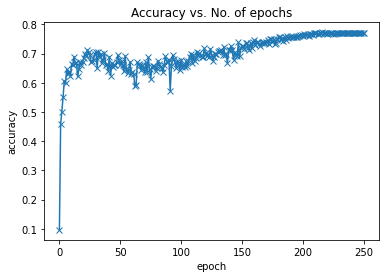

In [42]:
plot_accuracies(history)


In [43]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

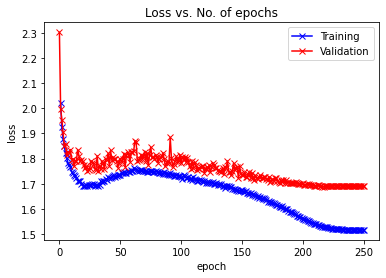

In [44]:
plot_losses(history)

In [45]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

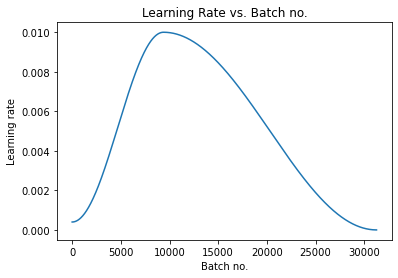

In [46]:
plot_lrs(history)

In [47]:

def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

## Testing the model

Label: airplane , Predicted: airplane


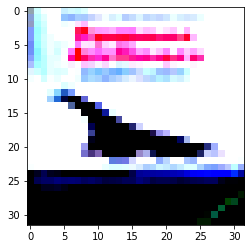

In [48]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: automobile , Predicted: truck


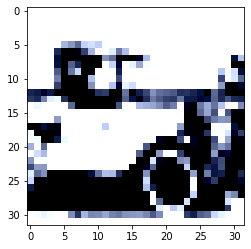

In [49]:
img, label = valid_ds[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: frog , Predicted: frog


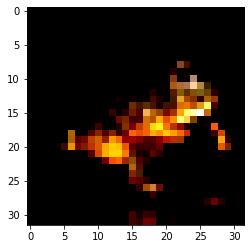

In [50]:
img, label = valid_ds[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))